In [2]:
using Optim, Dates, DiffEqParamEstim, Plots, Flux, DiffEqFlux, OrdinaryDiffEq

In [3]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

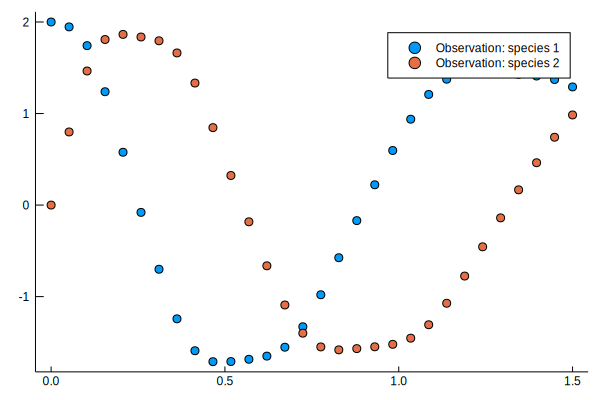

In [4]:
# Observation 
# Start conditions for the two species in the system
u0 = Float32[2.; 0.]
# Number of evaluations of the neural ODE. 
datasize = 30
# Time span in which of evaluation will be and actual timepoints of evaluations
tspan = (0.0f0, 1.5f0)
t = range(tspan[1], tspan[2], length = datasize)
# The true ODE (with the true parameters) which the neural net should learn
function trueODEfunc(du, u, p, t)
  true_A = [-0.1 2.0; -2.0 -0.1]
  du .= ((u.^3)'true_A)'
end
# Construction of the ODEProblem and solving the ODEProblem with Tsit5 solver
prob = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob, Tsit5(),saveat=t))
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")

In [13]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(x -> x.^3,
       Dense(2,50,tanh),
       Dense(50,2))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_, x, tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol = 1e-7, abstol = 1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
# to be set by user:
n_epochs_collocation = 5000
n_epochs_L2 = 100
n_epochs = n_epochs_collocation+n_epochs_L2
verify = 100 #every xth
data_collocation = Iterators.repeated((), n_epochs_collocation)
data_L2 = Iterators.repeated((), n_epochs_L2)
opt1 = ADAM(0.1)
opt2 = ADAM(0.1)
# Callback function to observe two stage training.
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end
cb2 = function ()
    sa.count_epochs = sa.count_epochs + 1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(L2_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(L2_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#51 (generic function with 1 method)

In [14]:
#two stage training call
@time Flux.train!(two_stage_loss_fct, ps, data_collocation, opt1, cb = cb1)
@time Flux.train!(L2_loss_fct, ps, data_L2, opt2, cb = cb2)

 40.449911 seconds (61.54 M allocations: 2.883 GiB, 1.82% gc time)
101.414828 seconds (359.45 M allocations: 19.339 GiB, 4.76% gc time)


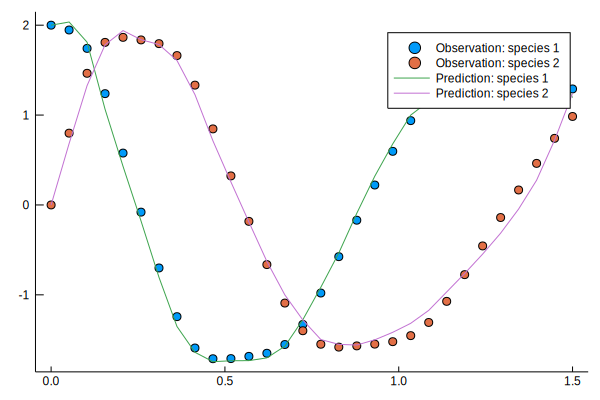

In [15]:
# Call n_ode to get first prediction and to show startpoint for training.
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = "Observation: species 1", grid = "off")
scatter!(t, ode_data[2,:], label = "Observation: species 2")
plot!(t, Flux.data(pred[1,:]), label = "Prediction: species 1")
plot!(t, Flux.data(pred[2,:]), label = "Prediction: species 2")

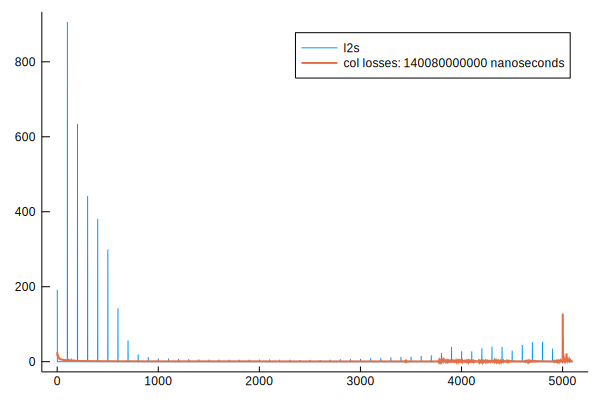

In [16]:
header = string("col losses: ", sa.times[end] - sa.times[1])
plot(range(1,stop=length(sa.l2s)),sa.l2s,label = "l2s", grid = "off")
plot!(range(1,stop=length(sa.losses)),sa.losses,width  =2, label = header)

In [17]:
#l2 vs first coll then l2
140080000000/786320000000

0.17814630176009766